# Scores Analysis

## Import

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt


from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm 
from ast import literal_eval
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr   
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.autograd import Variable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

## Configs

In [2]:
EXPERIMENTS = ['HRCE-1', 'HRCE-2']
PLATE_NUMBERS = {
    'HRCE-1': 26,
    'HRCE-2': 27
}

## Data Paths

In [8]:
DATA_PATH = '../../data'
ON_OFF_DISEASE_SCORE = 'scores/on-off_disease_score.csv'
DISEASE_SCORE = 'scores/disease_scores.csv'
METADATA_PATH = os.path.join(DATA_PATH, 'metadata.csv')

## Load Data

In [4]:
def load_metadata(metadata_path, experiments):
    def label(disease_condition):
        if  disease_condition == 0: return 'negctrl'
        else: return 'posctrl'
    metadata = pd.read_csv(metadata_path)    
    metadata = metadata[metadata.experiment.isin(experiments)]
    metadata.treatment = metadata.treatment.str.lower()
    metadata = metadata[['treatment', 'treatment_conc' , 'well_id', 'disease_condition']]
    metadata = metadata.fillna(0)
    metadata['label'] = metadata.apply(lambda row: label(row.disease_condition), axis=1)
    metadata = metadata.assign(
        groupid = metadata.groupby(
            ['treatment', 'treatment_conc', 'disease_condition']).ngroup())
    metadata = metadata.assign(
        treatmentid = metadata.groupby(
            ['treatment', 'disease_condition']).ngroup())
    return metadata

In [5]:
metadata = load_metadata(METADATA_PATH, EXPERIMENTS).set_index('well_id')

In [15]:
on_off_scores = pd.read_csv(ON_OFF_DISEASE_SCORE).set_index('well_id')

In [16]:
disease_scores = pd.read_csv(DISEASE_SCORE).set_index('well_id')

## Scores

In [17]:
scores = (
    disease_scores[[ 'disease_score', 'disease_sigmoid_score']]
    .join(on_off_scores[['on_score', 'off_score', 'sigmoid_on_score']])
    .join(metadata)
    .drop_duplicates()
    [['treatment', 'treatment_conc', 'disease_condition', 
      'disease_score', 'disease_sigmoid_score', 
      'on_score', 'off_score', 'sigmoid_on_score'
     ]]
)

print(scores.shape)
scores.describe()

(71013, 8)


,treatment_conc,disease_score,disease_sigmoid_score,on_score,off_score,sigmoid_on_score
count,71013.000000,71013.000000,71013.000000,7.101300e+04,7.101300e+04,71013.000000
mean,0.704338,25.799419,0.823737,1.751489e+03,9.082626e+02,0.568284
std,1.805829,3620.624298,0.256549,2.444638e+05,1.347973e+05,0.260873
min,0.000000,-24249.804688,0.000000,-3.430306e+04,2.487573e+01,0.000000
25%,0.010000,1.591208,0.830786,-5.544475e-01,4.118065e+01,0.364833
50%,0.100000,2.599557,0.930833,3.635802e-01,4.599392e+01,0.589907
75%,1.000000,3.407718,0.967945,1.301824e+00,5.290968e+01,0.786142
max,100.000000,813014.750000,1.000000,4.807666e+07,3.107052e+07,1.000000


## Violin Plots

In [18]:
def refine(x):
    if x == 0:
        return 'Control'
    else:
        return x
scores.disease_condition = scores.disease_condition.apply(lambda x: refine(x))

In [19]:
our_scores = scores[['disease_sigmoid_score', 'disease_condition', 'treatment_conc', 'treatment']]
our_scores.columns = ['score', 'condition', 'concentraition', 'treatment']
our_scores = our_scores.assign(source= 'Our Disease score model')

In [20]:
rxrx_scores = scores[['sigmoid_on_score', 'disease_condition', 'treatment_conc', 'treatment']]
rxrx_scores.columns = ['score', 'condition', 'concentraition', 'treatment']
rxrx_scores = rxrx_scores.assign(source='RxRx19a On-Disease score')

In [21]:
plot_scores = pd.concat([our_scores, rxrx_scores], axis=0, join='inner')
plot_scores.shape

(142026, 5)

In [25]:
conc_plot = plot_scores[plot_scores.treatment !=0]
conc_plot = conc_plot.assign(concentraition= conc_plot.concentraition.astype('category'))
conc_plot.dtypes

score              float64
condition           object
concentraition    category
treatment           object
source              object
dtype: object

/home/nmirzaie/.virtualenvs/tf2.6/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nmirzaie/.virtualenvs/tf2.6/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nmirzaie/.virtualenvs/tf2.6/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


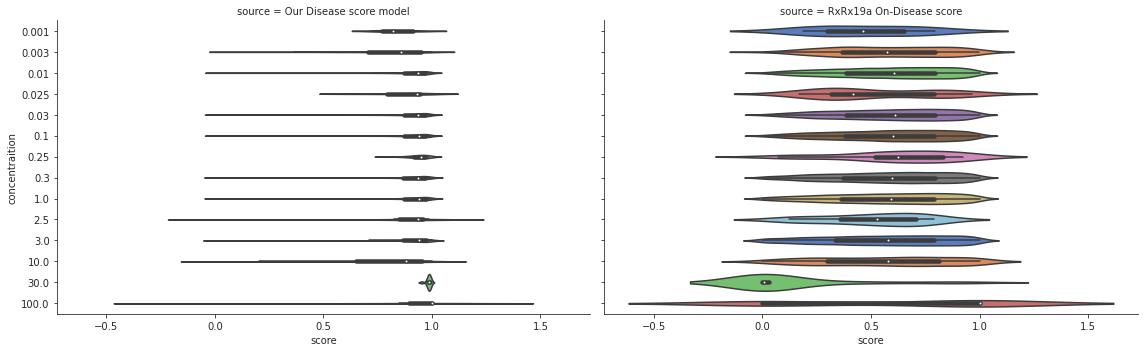

In [26]:
sns.set_style('ticks')
sns.catplot(
    x="score", y="concentraition", col='source', 
    data=conc_plot, split=True,  palette="muted",
    kind="violin", #order=["Control", "Mock", 'UV Inactivated SARS-CoV-2', 'Active SARS-CoV-2'],
    height=5, aspect=1.6,
)

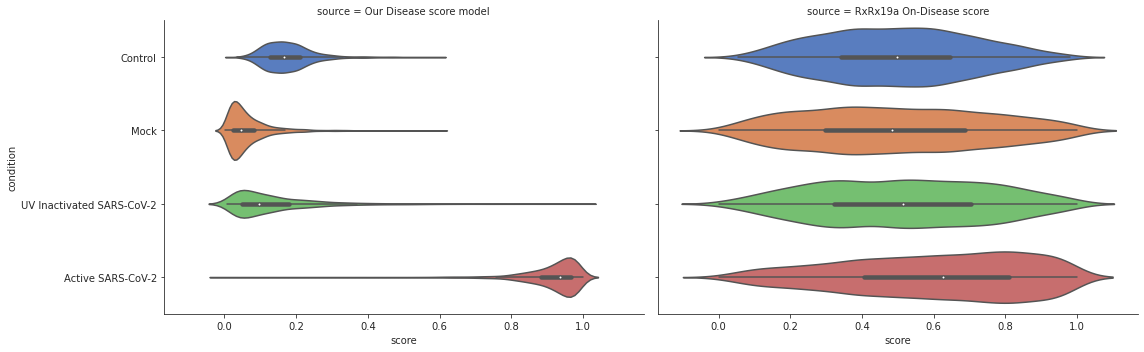

In [27]:
sns.set_style('ticks')
sns.catplot(
    x="score", y="condition", col='source', data=plot_scores[plot_scores.treatment == 0], 
    palette="muted", split=True,
    kind="violin", order=["Control", "Mock", 'UV Inactivated SARS-CoV-2', 'Active SARS-CoV-2'],
    height=5, aspect=1.6,
)

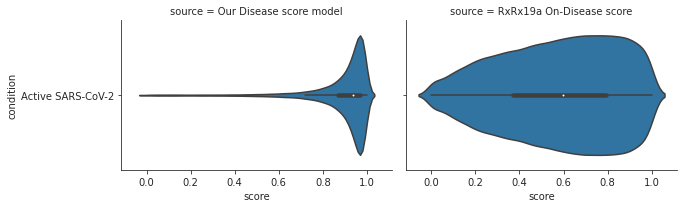

In [28]:
sns.set_style('ticks')
sns.catplot(
    x="score", y="condition", col='source', data=plot_scores[(plot_scores.treatment != 0)], #palette="Set1", 
    split=True,
    kind="violin",
     height=3, aspect=1.6,
)